# Applicazione di metodi per la MOO al modello di Markowitz

### Fabio Ciccarelli, matr. 1835348


### Import librerie e definizione funzioni utili

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import seaborn as sns
from itertools import permutations
import random
from tqdm.notebook import tqdm                                        


import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
print("")                                                              # Per ignorare i messaggi di warning 


try:
    import ipywidgets as widgets
except:
    !pip install ipywidgets

from ipywidgets import interact, interact_manual, fixed                 # Strumenti interattivi

In [2]:
'''Questa funzione è stata definita con l'intento di ottenere uno strumento utile a costruire i pesi da 
utilizzare nel metodo della somma pesata. In realtà, avendo provato il metodo solo per problemi bi-obiettivo, non ho avuto
modo di testarla. Ad ogni modo, utilizzando questo metodo di costruzione dei pesi ottieniamo pochi punti della frontiera di
Pareto (perchè, banalmente, eseguiamo poche iterazioni)''';

def build_priorities(p):
    w = []
    for i in range(p):
        act_priority = []
        weights = list(range(1, p+1))
        for j in range(i, len(weights)):
            act_priority.append(weights[j])
        for j in range(i):
            act_priority.append(weights[j])
        w.append(np.array(act_priority)/sum(act_priority))
        
    return w

In [3]:
'''Funzione per il filtraggio delle soluzioni debolmente non-dominate''';

def filter_wn(S):
    S_new = S.copy()
    
    for row1 in tqdm(S.index, desc = '***Eliminazione soluzioni debolmente non-dominate***'):
            for row2 in S.index:
                if S.loc[row1, 'y1']>=S.loc[row2, 'y1'] and S.loc[row1, 'y2']>=S.loc[row2, 'y2'] and \
                (S.loc[row1, 'y1']!=S.loc[row2, 'y1'] or S.loc[row1, 'y2']!=S.loc[row2, 'y2']):
                    S_new = S_new.drop( labels = [row1])
                    #print(S_new)
                    break
                    
    return(S_new)


    

## Definizione metodo dei pesi

In [4]:
# DEFINIZIONE METODO DEI PESI

def weighted_sum_method(functions, n, g, maxit):
    p = len(functions)
    
    if p == 2:
        w = []
        for delta in np.arange(0,1, 1/maxit):
            w.append([delta, 1-delta])
    else:
        w = build_priorities(p)
    
    X_we = {}
    Y_wn = {}          # Inizializzo due dizionari per salvare i punti Pareto-efficienti e le soluzioni non-dominate
    
    
    
    
    
    for i in tqdm(range(len(w)), desc = '***Applicazione metodo dei pesi***'):
    
        def F(x):
            return sum(functions[j](x)*w[i][j] for j in range(p))      # Creo la nuova f.o. come combinazione lineare delle 
                                                                        # p funzioni obiettivo del problema
            
        
        x_0 = np.random.rand(n)
        results = optimize.minimize(F, x_0/sum(x_0), constraints = g)
        
        if results['success'] == True:
            X_we[str(i)] = results['x']
            
            
            Y_wn[str(i)] = []
            
            
            for j in range(p):
                Y_wn[str(i)].append(functions[j](results['x']))            # Aggiorno i due dizionari X_we e Y_wn
                
                

    
    
    
        
    return Y_wn        # Restituisco solo Y_wn perché mi servirà per plottare la frontiera di Pareto
        
        
            
    

## Definizione metodo degli $\varepsilon$-vincoli

In [5]:
# DEFINIZIONE METODO DEGLI EPS-VINCOLI

def eps_constraint(functions, n, g, maxit, tan = False):
    p = len(functions)
    
    X_we = {}
    Y_wn = {}
    
    
    if tan == True:
        x_0 = np.array([0.5823332, 0.93769985])  # Nel caso di problema di Tanaka, è meglio partire da un punto ammissibile
        
    else:
        x_0 = np.random.rand(n)
        x_0 = x_0/sum(x_0)
        
    
    
    if p==2:
        x_1 = optimize.minimize(functions[0], x_0, constraints = g)['x']
        x_2 = optimize.minimize(functions[1], x_0, constraints = g)['x']   # Minimizzo le due f.o. singolarmente
        
        y_1 = [float(functions[0](x_1)),float(functions[1](x_1))]
        y_2 = [float(functions[0](x_2)),float(functions[1](x_2))]
        
        
        k = 0
    
        
        for eps in tqdm(np.arange(y_2[0], y_1[0], -(y_2[0]-y_1[0])/maxit), desc = '***Applicazione metodo eps-vincoli***'):
            g_ = []
            for c in g:
                g_.append(c)
            g_.append(optimize.NonlinearConstraint(functions[0], -np.inf, eps))
            
            
            
            Results = optimize.minimize(functions[1], np.random.rand(n), constraints = g_);
            if Results['success'] == False:
                continue
            
            Y_wn[str(k)] = []
            for j in range(p):
                Y_wn[str(k)].append(functions[j](Results['x']))  # Aggiorno i dizionari
                
            k = k+1
        
        if p>2:
            x_opt = optimize.minimize(functions[0], x_0, constraints = g)
            
            g_new = g + [(optimize.NonlinearConstraint(functions[0], -np.inf, functions[0](x_opt)))]
            
            functions_new = functions.pop(0)
            
            return eps_constraint(functions_new, n, g_new, maxit)  # Se p>2 applico ricorsivamente il metodo degli eps-vincoli
            
        return Y_wn

## Problema di Schaffer

Il problema di Schaffer è così definito:

$$
\begin{align}
&\min  \ \ \ \   (x^2, (x-2)^2) \\
& \ s.t.  \quad \   -10 \leq x \leq 10 
\end{align}
$$

Con la seguente frontiera di Pareto:

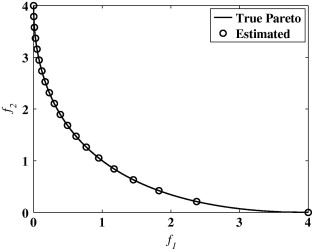

In [6]:
def Schaffer1(x):
    return x**2 

def Schaffer2(x):
    return (x-2)**2


Schaffer = [Schaffer1, Schaffer2]


def g1_schaf(x):
    return x

g1_schaffer = optimize.NonlinearConstraint(g1_schaf, -10, 10)

g_schaffer = [g1_schaffer]

## Problema di Tanaka

Il problema di Tanaka è così definito:

$$
\begin{align}
& min \ \ (x_1, x_2) \\
&s.t.\quad x_1^2+x_2^2 -1 - 0.1\cos ( 16\arctan  \frac{x_1}{x_2}) \geq 0 \\
& \  \ \quad \quad(x_1-0.5)^2+(x_2-0.5)^2 \leq 0.5 \\
&\\
& \ \ \quad \quad 0 \leq x \leq \pi 
\end{align}
$$

Con la seguente frontiera di Pareto:

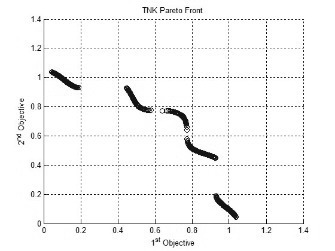



In [7]:
def Tanaka1(x):
    return x[0]

def Tanaka2(x):
    return x[1]

Tanaka = [Tanaka1, Tanaka2]

def g1_tan(x):
    return x[0]**2+x[1]**2-1-0.1*np.cos(16*np.arctan(x[0]/x[1]))

def g2_tan(x):
    return (x[0]-0.5)**2+(x[1]-0.5)**2 

def g3_tan(x):
    return x

g1_tanaka, g2_tanaka, g3_tanaka = optimize.NonlinearConstraint(g1_tan, 0, np.inf), optimize.NonlinearConstraint(g2_tan, -np.inf , 0.5), optimize.NonlinearConstraint(g3_tan, 0, np.pi)
    
g_tanaka = [g1_tanaka, g2_tanaka, g3_tanaka]

## Applicazione metodo dei pesi ai problemi di Schaffer e Tanaka

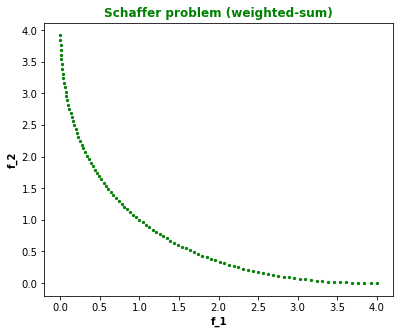

In [8]:
A = weighted_sum_method(Schaffer, 1, g_schaffer, 100)
D = pd.DataFrame(columns = ['y1', 'y2'])

for i in A:
    z =  {}
    z = {'y1': A[i][0], 'y2': A[i][1]}
    D = D.append(z, ignore_index = True)
    
    
plt.figure(figsize=(6.24,5.02))
plt.scatter(D.iloc[:, 0], D.iloc[:, 1], c = 'g', s=5);
plt.plot(D.iloc[:, 0], D.iloc[:, 1], linewidth = 0.1, color = 'gray');
plt.ylabel('f_2', rotation = 90, fontweight='bold');
plt.xlabel('f_1', fontweight = 'bold');
plt.title('Schaffer problem (weighted-sum)', fontweight = 'bold', color = 'green');

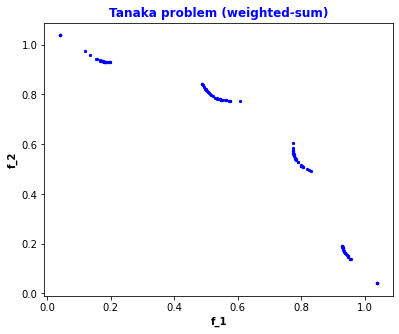

In [9]:
A = weighted_sum_method(Tanaka, 2, g_tanaka, 400)
D = pd.DataFrame(columns = ['y1', 'y2'])

for i in A:
    z =  {}
    z = {'y1': A[i][0], 'y2': A[i][1]}
    D = D.append(z, ignore_index = True)
    
   

D = filter_wn(D)

plt.figure(figsize=(6.24,5.02))
plt.scatter(D.iloc[:, 0], D.iloc[:, 1], c = 'b', s=5);
plt.ylabel('f_2', rotation = 90, fontweight='bold');
plt.xlabel('f_1', fontweight = 'bold');
plt.title('Tanaka problem (weighted-sum)', fontweight = 'bold', color = 'blue');

## Applicazione metodo degli $\varepsilon$-vincoli ai problemi di Schaffer e Tanaka

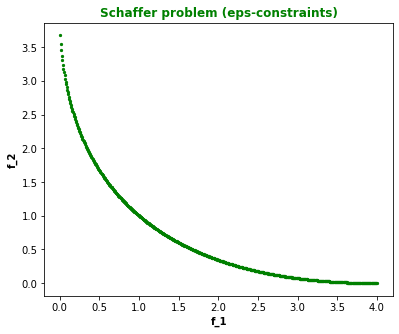

In [10]:
A = eps_constraint(Schaffer, 1, g_schaffer, 600)
D = pd.DataFrame(columns = ['y1', 'y2'])

for i in A:
    z =  {}
    z = {'y1': A[i][0], 'y2': A[i][1]}
    D = D.append(z, ignore_index = True)
    
    
plt.figure(figsize=(6.24,5.02))
plt.scatter(D.iloc[:, 0], D.iloc[:, 1], c = 'green', s=5);
plt.ylabel('f_2', rotation = 90, fontweight='bold');
plt.xlabel('f_1', fontweight = 'bold');
plt.title('Schaffer problem (eps-constraints)', fontweight = 'bold', color = 'green');

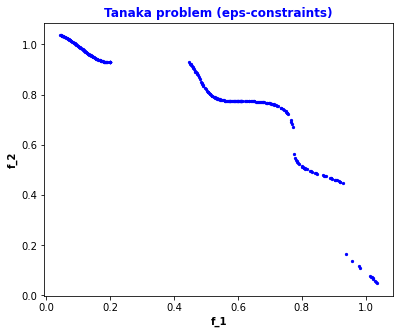

In [11]:
A = eps_constraint(Tanaka, 2, g_tanaka, 600, tan = True)
D = pd.DataFrame(columns = ['y1', 'y2'])

for i in A:
    z =  {}
    z = {'y1': A[i][0], 'y2': A[i][1]}
    D = D.append(z, ignore_index = True)
    
D = filter_wn(D)
    
    
plt.figure(figsize= (6.24,5.02))
plt.scatter(D.iloc[:, 0], D.iloc[:, 1], c = 'b', s=5);
plt.ylabel('f_2', rotation = 90, fontweight='bold');
plt.xlabel('f_1', fontweight = 'bold');
plt.title('Tanaka problem (eps-constraints)', fontweight = 'bold', color = 'blue');

# IL MODELLO DI MARKOWITZ


Il modello di Markowitz è un modello di ottimizzazione della ripartizione degli investimenti in un portafoglio. Tale modello si presta bene alle logiche di ottimizzazione multiobiettivo poiché richiede contemporaneamente di massimizzare il rendimento atteso dell'investimento, e di minimizzarne la variabilità.

Dati dunque n possibili investimenti, il modello può essere descritto dalle variabili e dai parametri seguenti:


$
\begin{align}
&x_i \quad i = 1,...,n \quad &\textit{Porzione di capitale impegnata nell'investimento i-esimo} \nonumber \\
&\mu_i \quad i = 1,...,n \quad &\textit{Rendimento atteso dell'investimento i-esimo} \nonumber \\
&\sigma_i \quad i = 1,...,n \quad & \textit{Variabilità dell'investimento i-esimo} \nonumber \\
&\rho_{ij} \quad i,j = 1,..., n \quad &\textit{Coefficiente di correlazione tra gli investimenti i-esimo e j-esimo} \nonumber 
\end{align}
$

Come già detto, l'obiettivo sarà dunque quello di massimizzare il rendimento complessivo dell'investimento, minimizzandone il rischio (inteso come variabilità del rendimento).



$\\
$


$$
\begin{align}
& min &(-\mu^Tx,\ \  x^TQx)  \nonumber \\
& s.t. &e^Tx = 1 \\
& & x \geq 0
\end{align}
$$

$\\
$


Con $\ \ e \in \mathbb{R}^n \ \ \ t.c. \ \ \ e_i = 1 \ \ \forall \ \ i \in \{1,...,n\}$ e $\ \ Q \in \mathbb{R}^{nxn} \ \ \ t.c. \ \ \ q_{ij} = \rho_{ij}\sigma_i\sigma_j$, vale a dire che Q è la matrice di covarianza degli investimenti considerati. Infatti:

$$
\begin{equation}
\rho_{x_1, x_2} = \frac{Cov \ (x_1,x_2)}{\sigma_{x_1}\sigma_{x_2}}
\end{equation}
$$

Si tratta dunque di un problema di ottimizzazione biobiettivo, con il vincolo che le variabili decisionali, positive, sommino a 1.
Inoltre, dal momento che la matrice di covarianza è simmetrica e semidefinita positiva, le due funzioni obiettivo che otteniamo sono l'una lineare, l'altra convessa (la stretta convessità dipende dalla possibilità che la matrice Q sia o meno singolare).

Procediamo dunque ad analizzare il comportamento dei due algoritmi definiti precedentemente (il metodo dei pesi e quello degli $\varepsilon$-vincoli) sul problema di MOO formulato poc'anzi ed applicato ad un portafoglio di 5 titoli azionari (Apple, Amazon, Microsoft, Goldman-Sachs e Pfizer).



## Formulazione del problema

In [12]:
num_var = 5


Markowitz = []

def f1_mark(x):
    return - mu @ x


Markowitz.append(f1_mark)

def f2_mark(x):
    return x @ (cov @ x)

Markowitz.append(f2_mark)


g_markowitz = []


g1_mark, g2_mark = optimize.LinearConstraint(np.ones(num_var), 1, 1), optimize.LinearConstraint(np.identity(num_var), np.zeros(num_var), np.inf)

g_markowitz.append(g1_mark)
g_markowitz.append(g2_mark)

## Caricamento dati

In [13]:
mu = np.array(pd.read_excel('data.xlsx', index_col=0, sheet_name = 'exp_ret').iloc[:, 0])

cov = np.array(pd.read_excel('data.xlsx', index_col = 0, sheet_name = 'Variance-covariance'))

cov = cov[2:][:]





# rho = np.array(pd.read_excel('data.xlsx', index_col = 0, sheet_name = 'Correlation_matrix'))

# rho = rho[2:][:]

# rho

### Analisi preliminare dei dati

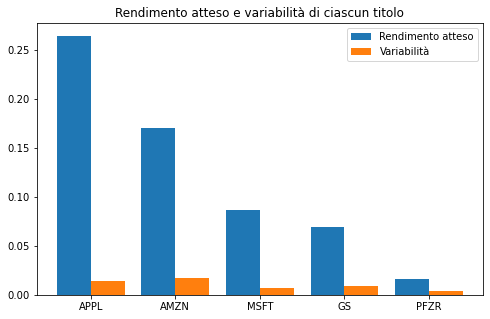

In [14]:
X = ['APPL','AMZN','MSFT','GS', 'PFZR']
mean = mu
var = []

for i in range(5):
    var.append((cov[i][i]))
  

X_axis = np.arange(len(X))

plt.figure(figsize = (8,5))
plt.bar(X_axis - 0.2, mean, 0.4, label = 'Rendimento atteso')
plt.bar(X_axis + 0.2, var, 0.4, label = 'Variabilità')
  
plt.xticks(X_axis, X)
plt.title("Rendimento atteso e variabilità di ciascun titolo")
plt.legend()
plt.show()

### Matrice di correlazione

In [15]:
titles = ['APPL','AMZN','MSFT','GS','PFZR']

corr_matr = pd.DataFrame(index = titles, columns = titles)



for i in range (5):
    for j in range(5):
        corr_matr.iloc[i, j] = cov[i][j]/(np.sqrt(cov[i][i])*np.sqrt(cov[j][j]))
        


corr_matr.fillna(value=np.nan, inplace=True)

# corr_matr

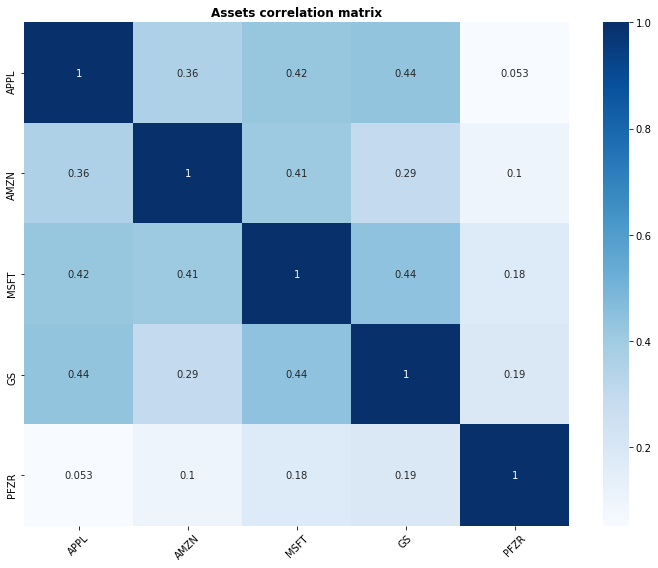

In [16]:
fig, ax = plt.subplots(figsize = (10,8) )
ax.set_title("Assets correlation matrix", fontweight = "bold")
sns.heatmap(corr_matr, annot = True, cmap = 'Blues',
           xticklabels = corr_matr.columns, yticklabels = corr_matr.columns, ax = ax)




ax.set_xticklabels(labels = corr_matr.columns, rotation = 45)

fig.tight_layout()

### Risultati ottenuti applicando il modello di Markowitz mono-obiettivo

In [17]:
def my_autopct(pct):
    return ('%.2f' % pct) if pct > 0 else ''


def opt_mark(R, n):
    
    
    R = R/100
    x_0 = np.random.rand(n)
    
    g_star = g_markowitz.copy()
    g_star.append(optimize.LinearConstraint(mu, R, np.inf))
    
    results = optimize.minimize(f2_mark, x_0/sum(x_0), constraints = g_star)
    percentages = abs(np.round(100*results['x'], 5))
    
    co_to_plot = []
    pct_to_plot = []
    
    
    for i in range(len(titles)):
        if percentages[i] > 0:
            pct_to_plot.append(percentages[i])
            co_to_plot.append(titles[i])
            
    plt.pie(pct_to_plot, labels = co_to_plot)
        
    
    for i in range(len(titles)):
        if percentages[i] >= 1:
            print(f'La porzione di capitale da investire in {titles[i]} è del {percentages[i]}%')
            print('*'*100)
        else:
            print(f'La porzione di capitale da investire in {titles[i]} è dello {percentages[i]}%')
            print('*'*100)
            
            
    print(f'La variabilità del protafoglio così costituito è dello {results["fun"]*100} %')


    return 

interact(opt_mark,
        R = widgets.IntSlider(10, 5, 25, 5),
        n = fixed(5));



interactive(children=(IntSlider(value=10, description='R', max=25, min=5, step=5), Output()), _dom_classes=('w…

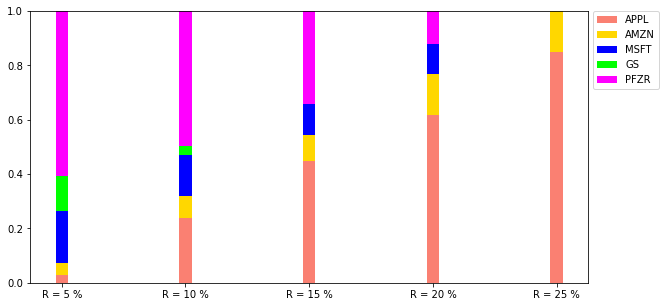

In [18]:
d = {'APPL': [], 'AMZN': [], 'MSFT':[], 'GS':[], 'PFZR':[]}

for i in np.arange(0.05,0.30,0.05):
    
    x_0 = np.random.rand(num_var)
    
    x_0 = x_0/sum(x_0)
    
    g_star = g_markowitz.copy()
    
    g_star.append(optimize.LinearConstraint(mu, i, +np.inf))
    
    results = optimize.minimize(f2_mark, x_0, constraints = g_star)['x']
    
    for j in range(len(results)):
        d[list(d.keys())[j]].append(abs(results[j]))


fig, ax = plt.subplots(figsize = (10,5))
width = 0.1

x_lab = ['R = 5 %','R = 10 %','R = 15 %','R = 20 %','R = 25 %']

ax.bar(x_lab, d['APPL'], width, color='salmon', label='APPL')
ax.bar(x_lab, d['AMZN'], width, color='gold', label='AMZN',bottom = d['APPL'])
ax.bar(x_lab, d['MSFT'], width, color='blue', label='MSFT',bottom = np.array(d['APPL']) + np.array(d['AMZN']))
ax.bar(x_lab, d['GS'], width, color='lime', label='GS',bottom=np.array(d['APPL']) + np.array(d['AMZN']) + np.array(d['MSFT']))
ax.bar(x_lab, d['PFZR'], width, color='magenta', bottom=np.array(d['APPL']) + np.array(d['AMZN']) + np.array(d['MSFT'])+ np.array(d['GS']),
       label='PFZR')
ax.legend(bbox_to_anchor=(1,1.02));

## Applicazione metodo dei pesi

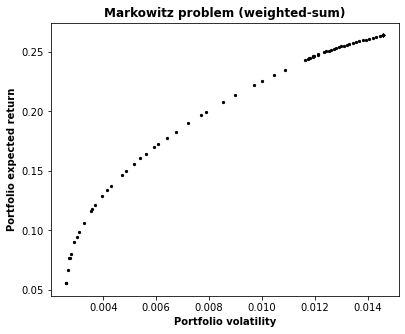

In [19]:
A = weighted_sum_method(Markowitz, 5, g_markowitz, 400)
D = pd.DataFrame(columns = ['y1', 'y2'])

for i in A:
    z =  {}
    z = {'y1': A[i][0], 'y2': A[i][1]}
    D = D.append(z, ignore_index = True)
    
D = filter_wn(D)
    
plt.figure(figsize=(6.24,5.02))
plt.scatter( D.iloc[:, 1], - D.iloc[:, 0], c = 'black', s=5);
# plt.plot(D.iloc[:, 0], D.iloc[:, 1], linewidth = 0.1, color = 'gray');
plt.ylabel('Portfolio expected return', rotation = 90, fontweight='bold');
plt.xlabel('Portfolio volatility', fontweight = 'bold');
plt.title('Markowitz problem (weighted-sum)', fontweight = 'bold', color = 'black');


## Applicazione metodo degli $\varepsilon$-vincoli

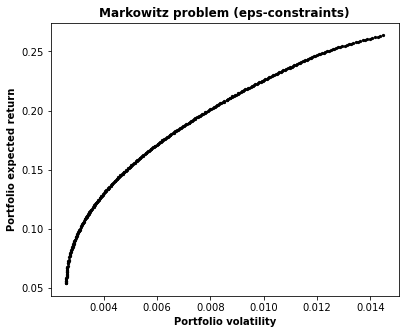

In [20]:
A = eps_constraint(Markowitz, 5, g_markowitz, 400)
D = pd.DataFrame(columns = ['y1', 'y2'])

for i in A:
    z =  {}
    z = {'y1': A[i][0], 'y2': A[i][1]}
    D = D.append(z, ignore_index = True)
    
D = filter_wn(D)
    
plt.figure(figsize=(6.24,5.02))
plt.scatter( D.iloc[:, 1], - D.iloc[:, 0], c = 'black', s=5);
# plt.plot(D.iloc[:, 0], D.iloc[:, 1], linewidth = 0.1, color = 'gray');
plt.ylabel('Portfolio expected return', rotation = 90, fontweight='bold');
plt.xlabel('Portfolio volatility', fontweight = 'bold');
plt.title('Markowitz problem (eps-constraints)', fontweight = 'bold', color = 'black');

